# Creating Panoramas using OpenCV

**Satya Mallick, LearnOpenCV.com**

In [1]:
# Import Libraries
import os
import cv2
import math
import glob
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

##  <font style="color:black">Download Assets</font>

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/0o5yqql1ynx31bi/opencv_bootcamp_assets_NB9.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB9.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

# Steps for Creating Panoramas

1. Find keypoints in all images
2. Find pairwise correspondences
2. Estimate pairwise Homographies
3. Refine Homographies
3. Stitch with Blending

# Steps for Creating Panoramas using OpenCV

In [9]:
# Read Images

imagefiles = glob.glob(f"boat{os.sep}*")
print(imagefiles)
imagefiles.sort()
print(imagefiles)

images = []
for filename in imagefiles:
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

num_images = len(images)
print(num_images)
print(type(images))
print(type(images[0]))

['boat/boat6.jpg', 'boat/boat2.jpg', 'boat/boat4.jpg', 'boat/boat5.jpg', 'boat/boat1.jpg', 'boat/boat3.jpg']
['boat/boat1.jpg', 'boat/boat2.jpg', 'boat/boat3.jpg', 'boat/boat4.jpg', 'boat/boat5.jpg', 'boat/boat6.jpg']
6
<class 'list'>
<class 'numpy.ndarray'>


这两行代码的作用是获取指定目录下的所有图像文件，并按文件名进行排序。以下是详细解释：

### 第一行代码：
```python
imagefiles = glob.glob(f"boat{os.sep}*")
```

1. `glob.glob()`: 这是Python的glob模块中的一个函数，用于根据指定的路径模式匹配文件路径名。
2. `f"boat{os.sep}*"`: 这是一个f-string格式的字符串：
   - `boat`: 表示目录名
   - `os.sep`: 这是操作系统特定的路径分隔符（在Windows上是`\`，在Linux/macOS上是`/`）
   - `*`: 通配符，表示匹配该目录下的所有文件
3. 整体效果是：获取"boat"目录下的所有文件的路径列表

例如，在Windows上会匹配`boat\*`，在Linux上会匹配`boat/*`。

### 第二行代码：
```python
imagefiles.sort()
```

1. 对`imagefiles`列表进行原地排序（直接修改原列表，不返回新列表）
2. 排序是按照字符串的字典序进行的，也就是按文件名排序

### 综合效果：
这两行代码组合起来的作用是：获取"boat"目录下的所有文件路径，并按文件名顺序排序后存储在`imagefiles`列表中。

注意事项：
1. 这会匹配目录下的所有文件，包括非图像文件
2. 如果需要只匹配图像文件，通常会加上扩展名限制，如：`glob.glob(f"boat{os.sep}*.jpg")`
3. 排序是基于字符串比较的，对于数字编号的文件（如img1, img2,...img10），可能需要特殊处理才能正确排序

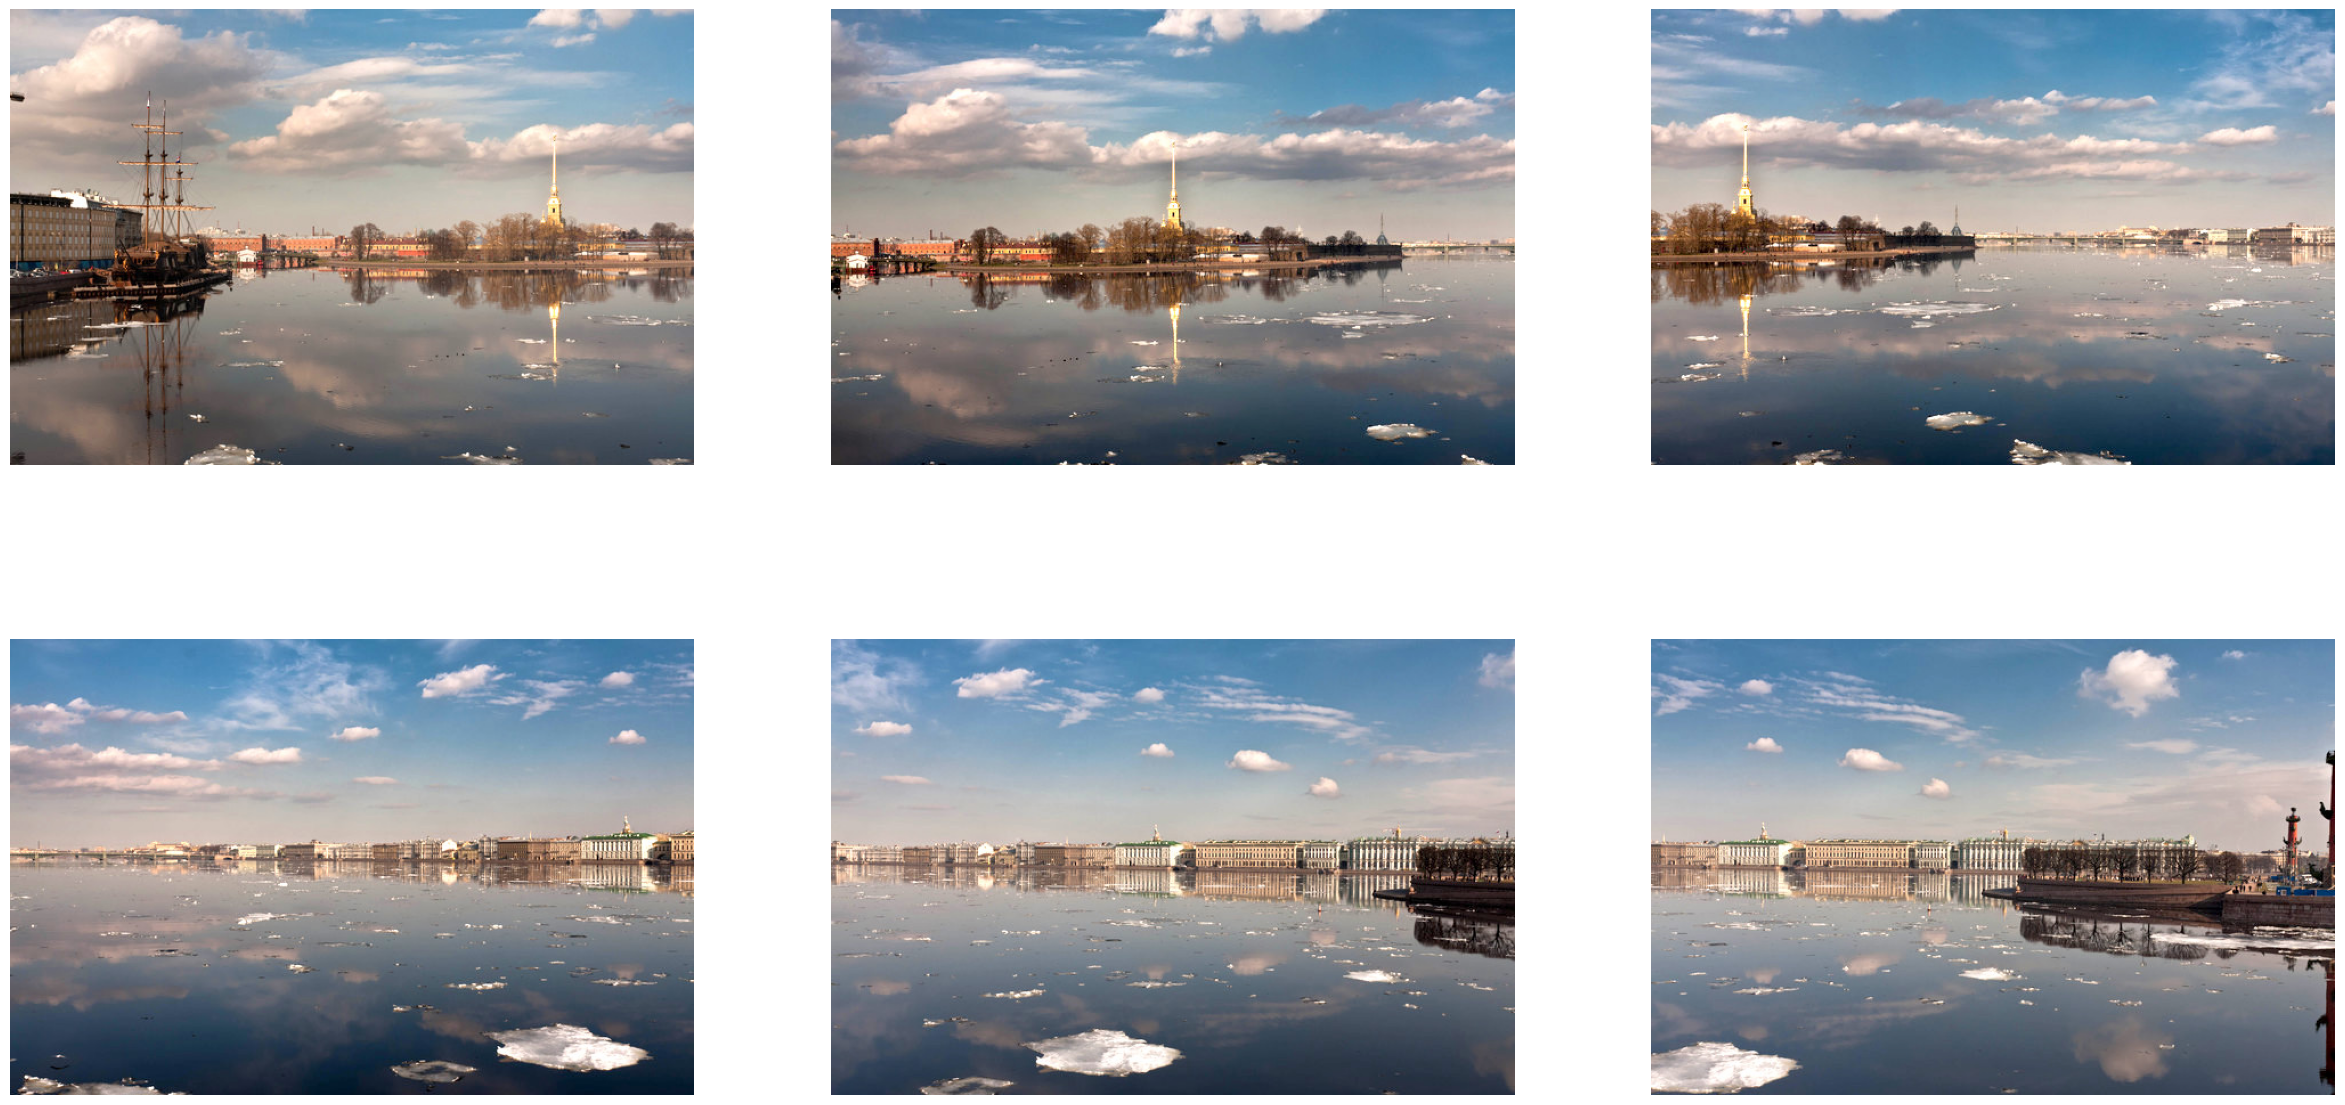

In [14]:
# Display Images
plt.figure(figsize=[30, 15])
num_cols = 3
num_rows = math.ceil(num_images / num_cols)
for i in range(0, num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.axis("off")
    plt.imshow(images[i])
plt.show()

Use the **sticher** class

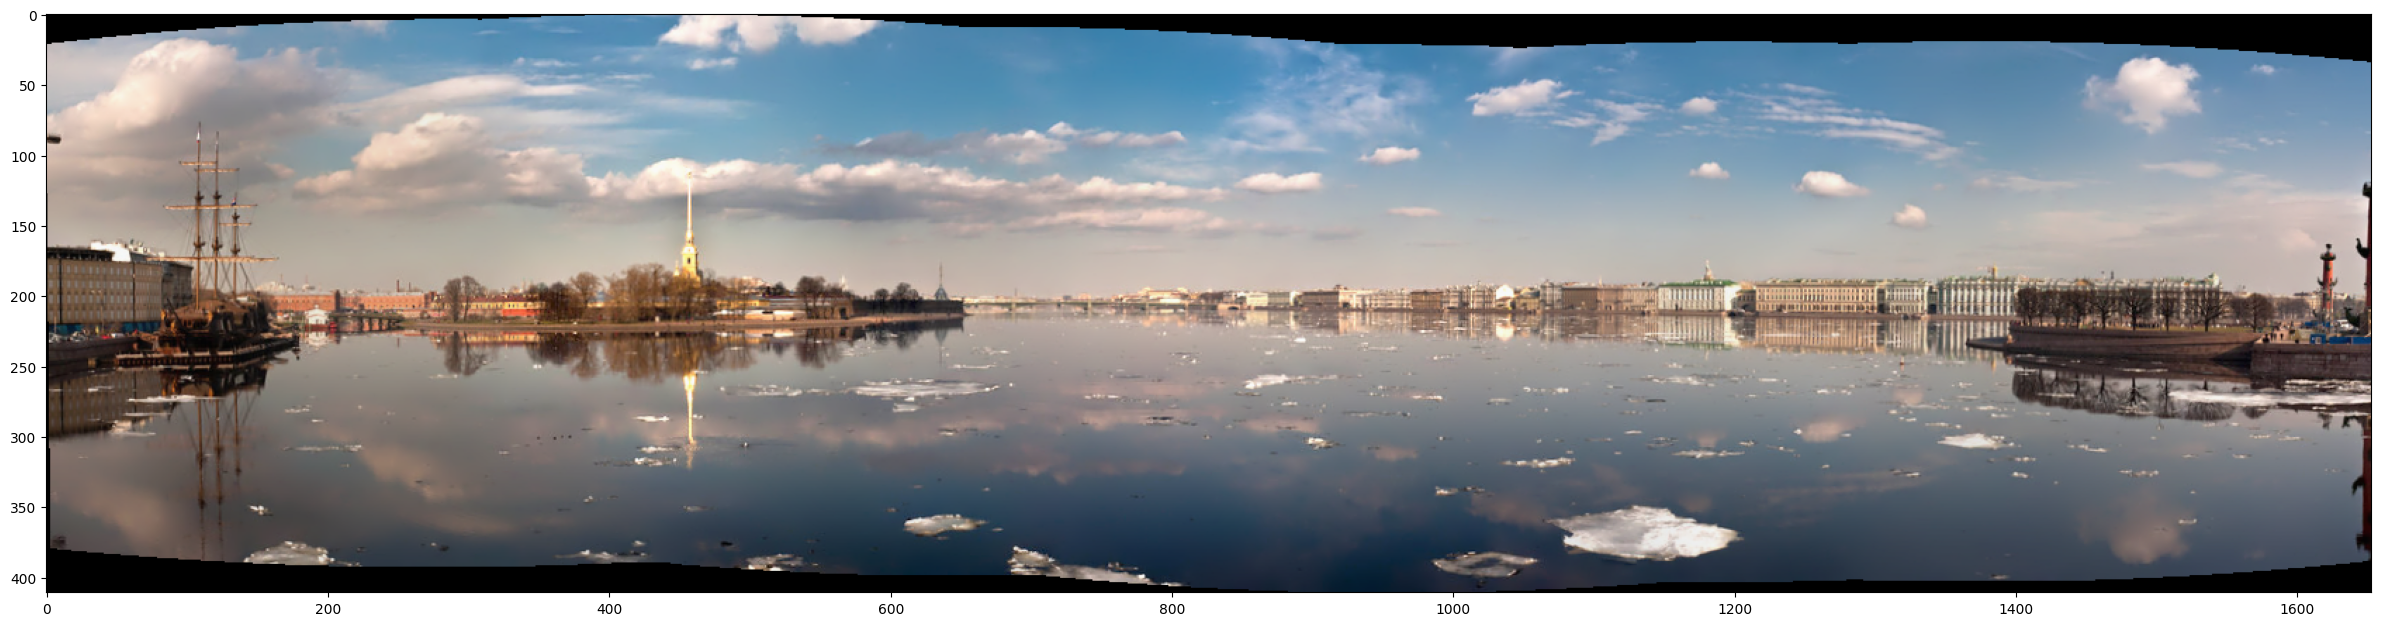

In [15]:
# Stitch Images
stitcher = cv2.Stitcher_create()
status, result = stitcher.stitch(images)

if status == 0:
    plt.figure(figsize=[30, 10])
    plt.imshow(result)
plt.show()

这段代码使用OpenCV的`cv2.Stitcher`类来拼接（stitch）多张图像，生成全景图。以下是详细解释：

---

### **1. 创建拼接器对象**
```python
stitcher = cv2.Stitcher_create()
```
- **功能**：  
  调用`cv2.Stitcher_create()`创建一个图像拼接器对象`stitcher`。  
- **参数**：  
  默认使用`cv2.Stitcher_PANORAMA`模式（适用于全景拼接）。  
  如果需要更高性能但精度较低，可指定模式为`cv2.Stitcher_SCANS`（适用于扫描文档拼接）：
  ```python
  stitcher = cv2.Stitcher_create(cv2.Stitcher_SCANS)
  ```

---

### **2. 执行图像拼接**
```python
status, result = stitcher.stitch(images)
```
- **输入参数 `images`**：  
  一个包含多张图像的列表（`[img1, img2, ...]`），所有图像需为相同尺寸和数据类型（通常为BGR格式的`numpy`数组）。
  
- **返回值**：  
  - `status`：操作状态码（成功或错误类型）。  
  - `result`：拼接结果图像（全景图），如果失败则返回`None`。

---

### **3. 状态码（`status`）的含义**
| 状态码                     | 值  | 含义                          |
|---------------------------|-----|-----------------------------|
| `cv2.Stitcher_OK`         | 0   | 拼接成功                      |
| `cv2.Stitcher_ERR_NEED_MORE_IMGS` | 1 | 输入图像不足（至少需要2张）     |
| `cv2.Stitcher_ERR_HOMOGRAPHY_EST_FAIL` | 2 | 特征匹配或单应性矩阵计算失败 |
| `cv2.Stitcher_ERR_CAMERA_PARAMS_ADJUST_FAIL` | 3 | 相机参数优化失败          |

---

### **4. 完整示例代码**
```python
import cv2

# 读取多张图像
image1 = cv2.imread("img1.jpg")
image2 = cv2.imread("img2.jpg")
images = [image1, image2]

# 创建拼接器并执行拼接
stitcher = cv2.Stitcher_create()
status, panorama = stitcher.stitch(images)

# 检查结果
if status == cv2.Stitcher_OK:
    cv2.imshow("Panorama", panorama)
    cv2.waitKey(0)
else:
    print(f"拼接失败，错误码: {status}")
```

---

### **5. 注意事项**
1. **图像要求**：  
   - 图像需有重叠区域（建议重叠30%~50%）。  
   - 图像需为相同分辨率、未压缩或轻度压缩（避免JPEG artifacts影响特征匹配）。  

2. **失败常见原因**：  
   - 图像重叠不足或光线差异过大。  
   - 动态物体（如行人）干扰特征匹配。  

3. **性能优化**：  
   - 对大量图像拼接时，可先使用`stitcher.estimateTransform()`预计算变换矩阵，再调用`stitcher.composePanorama()`生成结果。

---

通过以上步骤，你可以将多张部分重叠的图像拼接成一张全景图。如果遇到问题，建议先检查输入图像的质量和重叠区域。